<div align="right"><b>Бронников Егор ПМ-1901</b></div>

# SARIMA (3,1,2) (1,1,0)

## Модули

In [1]:
import numpy as np
import pandas as pd

from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline

## Данные

In [2]:
passengers = pd.read_csv('data/passengers.csv', index_col='date', parse_dates=True)

In [3]:
passengers.head()

,num_passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
passengers["num_passengers"] *= 10000

In [5]:
passengers.head()

,num_passengers
date,
1949-01-01,1120000
1949-02-01,1180000
1949-03-01,1320000
1949-04-01,1290000
1949-05-01,1210000


## Подготовка данных

**Преобразование Бокса-Кокса**

In [6]:
def boxcox(data, lambda_):
    return np.log(data) if lambda_ == 0 else (data**lambda_-1)/lambda_

In [7]:
boxcox(passengers["num_passengers"], 0.5)

date
1949-01-01    2114.601049
1949-02-01    2170.556098
1949-03-01    2295.825059
1949-04-01    2269.563338
1949-05-01    2198.000000
                 ...     
1960-08-01    4921.413450
1960-09-01    4505.771068
1960-10-01    4292.182111
1960-11-01    3947.683532
1960-12-01    4154.921938
Name: num_passengers, Length: 144, dtype: float64

**Целевая функция**

In [8]:
def func(data, lambda_):
    T = data.shape[0]
    return T/2*np.log(np.sum((boxcox(data,lambda_)-np.mean(boxcox(data,lambda_)))**2)/T)-(lambda_-1)*np.sum(np.log(data))

**Подбор параметра $\lambda$**

In [9]:
optimization = minimize(lambda x: func(passengers["num_passengers"], x[0]), (0))

print(optimization)
lambda_ = optimization.x

      fun: 2006.1152687017877
 hess_inv: array([[1]])
      jac: array([2.23298645])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 38
      nit: 0
     njev: 13
   status: 2
  success: False
        x: array([0.])


/tmp/ipykernel_2323044/4199650581.py:3: RuntimeWarning: divide by zero encountered in log
  return T/2*np.log(np.sum((boxcox(data,lambda_)-np.mean(boxcox(data,lambda_)))**2)/T)-(lambda_-1)*np.sum(np.log(data))


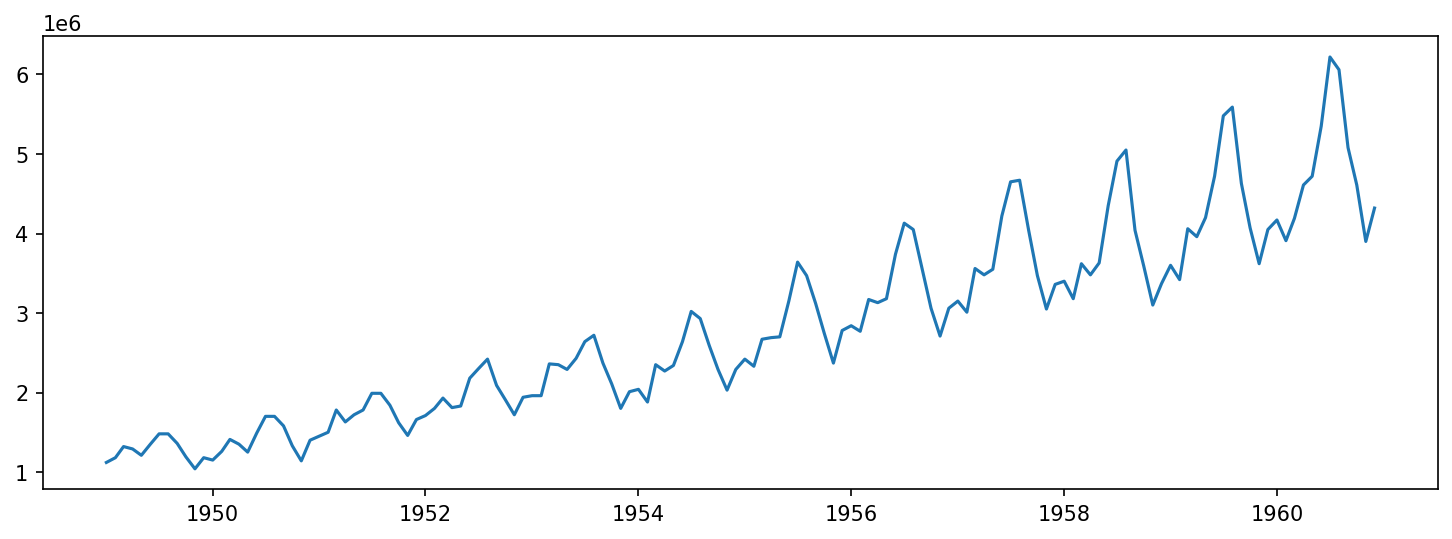

In [10]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(passengers["num_passengers"])
plt.show()

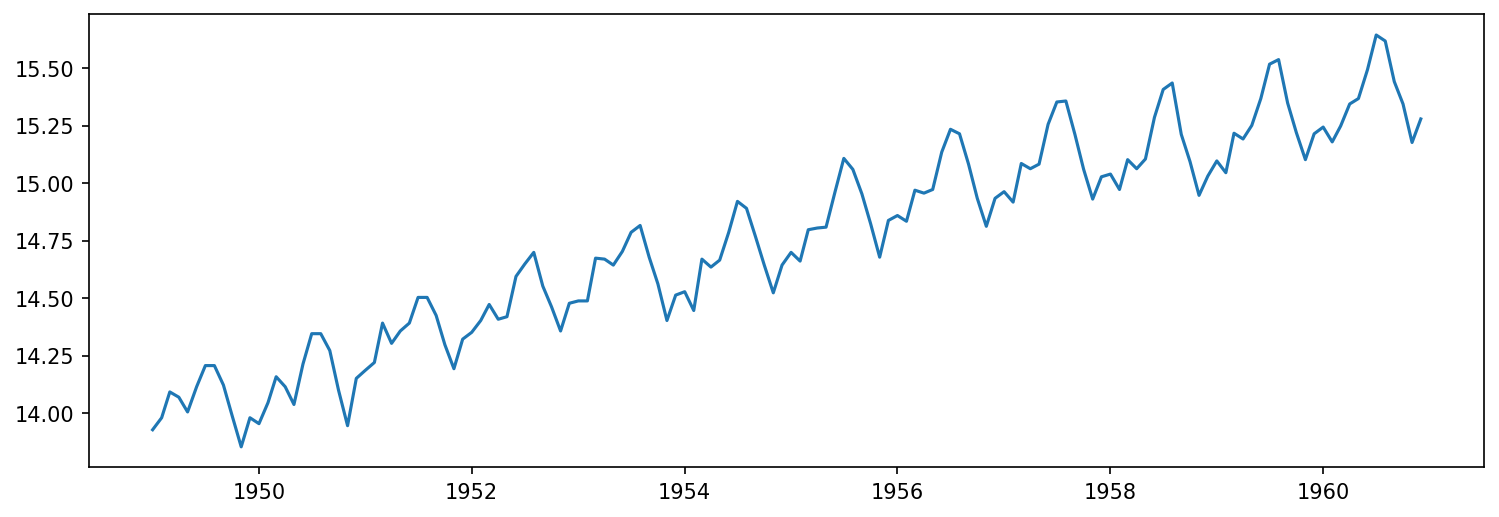

In [11]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(boxcox(passengers["num_passengers"], lambda_))
plt.show()

**Функция дифференцирования**

In [12]:
def diff(data, lag):
    return [data[t]-data[t-lag] for t in range(lag, len(data))]

**Сезонное дифференцирование**

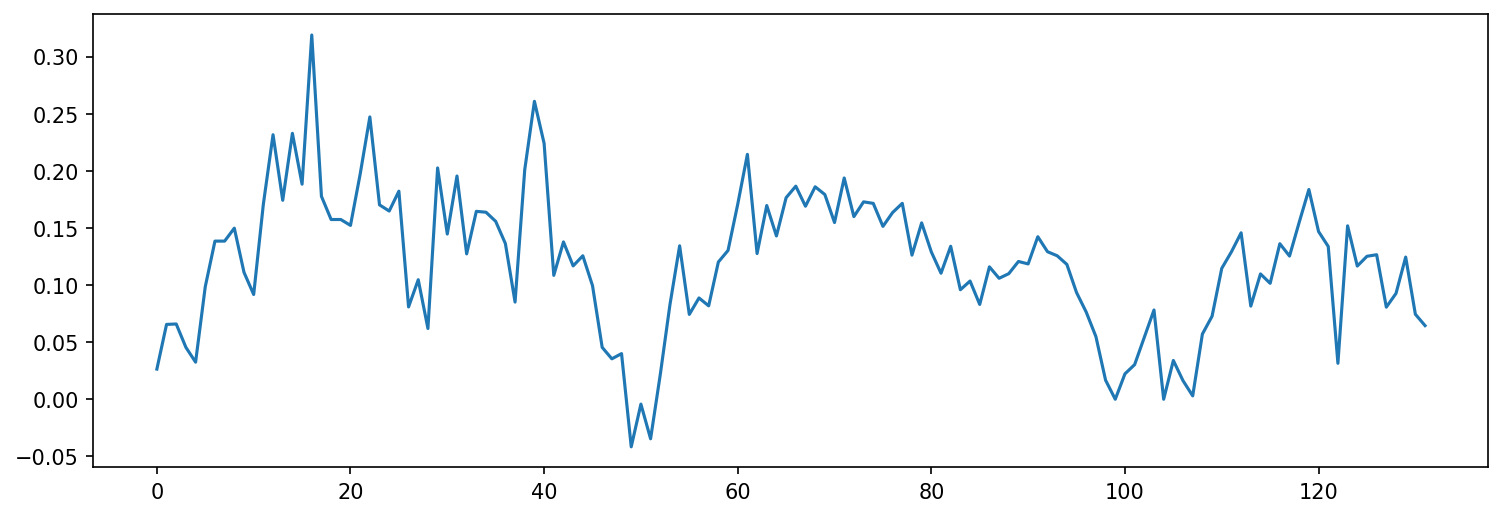

In [13]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(diff(boxcox(passengers["num_passengers"], lambda_), 12))
plt.show()

**Ещё одно дифференцирование**

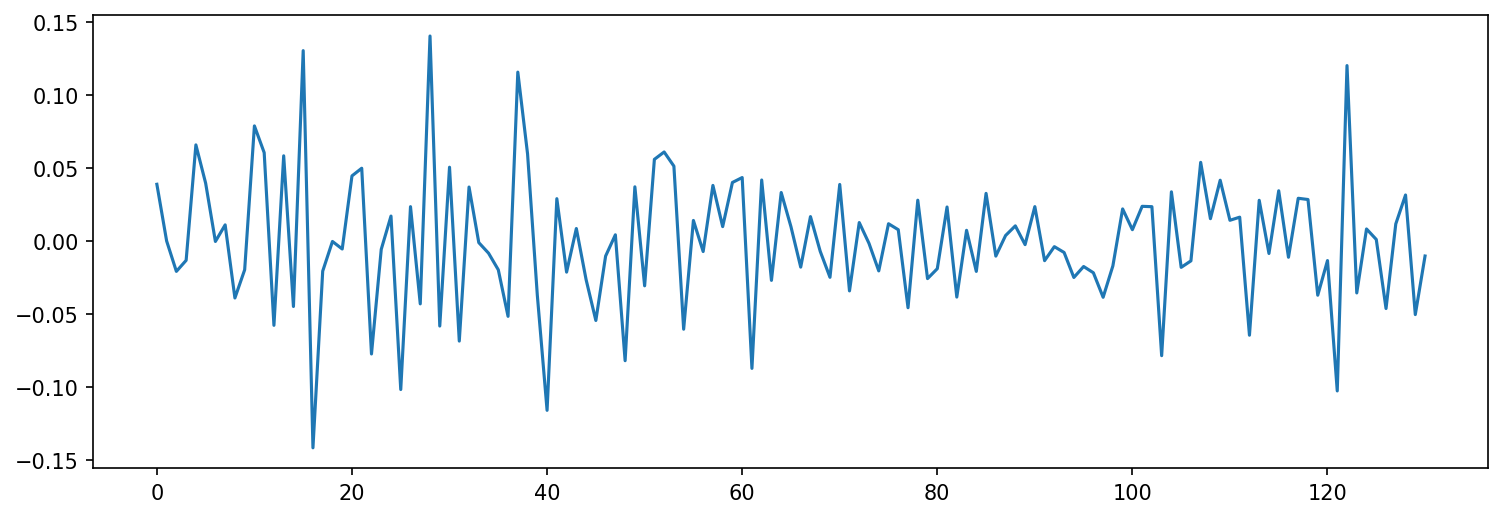

In [14]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(diff(diff(boxcox(passengers["num_passengers"], lambda_), 12), 1))
plt.show()

**Всё ещё подготовка данных**

In [15]:
y = passengers["num_passengers"].values

y_bx = boxcox(passengers["num_passengers"], lambda_).values

sd = diff(boxcox(passengers["num_passengers"], lambda_), 12)
y_sd = [np.nan if i < 12 else sd[i-12] for i in range(len(y))]

d1 = diff(diff(boxcox(passengers["num_passengers"], lambda_), 12), 1)
y_d1 = [np.nan if i < 13 else d1[i-13] for i in range(len(y))]

data = pd.DataFrame({"y": y,
                   "y_bx": y_bx,
                   "y_sd": y_sd,
                   "y_d1": y_d1
                  })
data.head(20)

,y,y_bx,y_sd,y_d1
0,1120000,13.928839,NaN,NaN
1,1180000,13.981025,NaN,NaN
2,1320000,14.093142,NaN,NaN
3,1290000,14.070153,NaN,NaN
4,1210000,14.006131,NaN,NaN
5,1350000,14.115615,NaN,NaN
6,1480000,14.207553,NaN,NaN
7,1480000,14.207553,NaN,NaN
8,1360000,14.122995,NaN,NaN
9,1190000,13.989464,NaN,NaN


## SARIMA

### AR

In [16]:
dfna = pd.DataFrame((data["y_d1"].dropna()).values, columns=["y"])
dfna.head()

,y
0,0.039164
1,0.000361
2,-0.020496
3,-0.012939
4,0.066148


In [17]:
dfna["y1"] = dfna["y"].shift(1)
dfna["y2"] = dfna["y"].shift(2)
dfna["y3"] = dfna["y"].shift(3)
dfna["y12"] = dfna["y"].shift(12)

In [18]:
dfna.head(13)

,y,y1,y2,y3,y12
0,0.039164,NaN,NaN,NaN,NaN
1,0.000361,0.039164,NaN,NaN,NaN
2,-0.020496,0.000361,0.039164,NaN,NaN
3,-0.012939,-0.020496,0.000361,0.039164,NaN
4,0.066148,-0.012939,-0.020496,0.000361,NaN
5,0.039915,0.066148,-0.012939,-0.020496,NaN
6,0.000000,0.039915,0.066148,-0.012939,NaN
7,0.011354,0.000000,0.039915,0.066148,NaN
8,-0.038715,0.011354,0.000000,0.039915,NaN
9,-0.019418,-0.038715,0.011354,0.000000,NaN


In [19]:
df = dfna.dropna()
df.head()

,y,y1,y2,y3,y12
12,-0.057448,0.060844,0.079150,-0.019418,0.039164
13,0.058670,-0.057448,0.060844,0.079150,0.000361
14,-0.044548,0.058670,-0.057448,0.060844,-0.020496
15,0.130705,-0.044548,0.058670,-0.057448,-0.012939
16,-0.141343,0.130705,-0.044548,0.058670,0.066148


**Среднеквадратичная ошибка**

In [20]:
def mse(data, phi1, phi2, phi3, phi12, alpha):
    return np.mean((data["y"] - (alpha + phi1*data["y1"] + phi2*data["y2"] + phi3*data["y3"] + phi12*data["y12"]))**2)

**Оптимизация**

In [21]:
opfunc = lambda x: mse(df, x[0], x[1], x[2], x[3], x[4])

optimization = minimize(opfunc, (0, 0, 0, 0, 0))

print(optimization)
phi1, phi2, phi3, phi12, alpha = optimization.x

      fun: 0.001439712092498003
 hess_inv: array([[ 2.22904895e+02,  2.85092037e+01, -6.96382393e+01,
         3.10597236e+01,  6.07413622e-02],
       [ 2.85092037e+01,  1.83992119e+02, -1.46040397e+01,
         7.18672107e+01, -2.09402554e-01],
       [-6.96382393e+01, -1.46040397e+01,  1.40047798e+02,
         4.25870468e+01, -1.94393293e-01],
       [ 3.10597236e+01,  7.18672107e+01,  4.25870468e+01,
         1.92723927e+02, -1.89684049e-01],
       [ 6.07413622e-02, -2.09402554e-01, -1.94393293e-01,
        -1.89684049e-01,  4.65283844e-01]])
      jac: array([ 3.46619345e-06,  4.19848948e-06,  6.93733455e-06, -5.20034519e-06,
        4.21078585e-06])
  message: 'Optimization terminated successfully.'
     nfev: 222
      nit: 34
     njev: 37
   status: 0
  success: True
        x: array([-0.36939901, -0.0682146 , -0.09929452, -0.40176926, -0.0011682 ])


In [22]:
ar = alpha + phi1*df["y1"] + phi2*df["y2"] + phi3*df["y3"] + phi12*df["y12"]

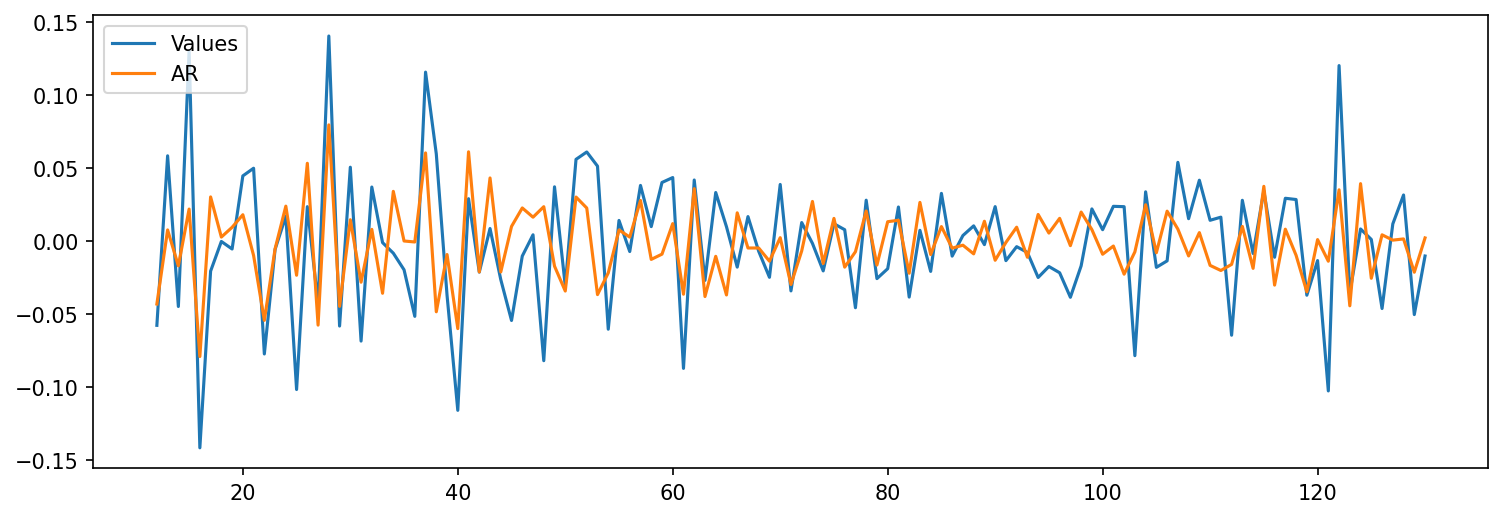

In [23]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(df["y"], label="Values")
plt.plot(ar, label="AR")
plt.legend(loc="upper left")
plt.show()

### MA

In [24]:
dfna["eps"] = dfna["y"] - ar
dfna["eps1"] = dfna["eps"].shift(1)
dfna["eps2"] = dfna["eps"].shift(2)

In [25]:
df = dfna.dropna()
df.head()

,y,y1,y2,y3,y12,eps,eps1,eps2
14,-0.044548,0.058670,-0.057448,0.060844,-0.020496,-0.027819,0.050772,-0.014598
15,0.130705,-0.044548,0.058670,-0.057448,-0.012939,0.108517,-0.027819,0.050772
16,-0.141343,0.130705,-0.044548,0.058670,0.066148,-0.062530,0.108517,-0.027819
17,-0.020331,-0.141343,0.130705,-0.044548,0.039915,-0.050846,-0.062530,0.108517
18,0.000000,-0.020331,-0.141343,0.130705,0.000000,-0.003005,-0.050846,-0.062530


**Среднеквадратичная ошибка**

In [26]:
def mse(data, theta1, theta2, alpha):
    return np.mean((data["eps"] - (alpha + theta1*data["eps1"] + theta2*data["eps2"]))**2)

**Оптимизация**

In [27]:
opfunc = lambda x: mse(df, x[0], x[1], x[2])

optimization = minimize(opfunc, (0, 0, 0))

print(optimization)
theta1, theta2, alpha2 = optimization.x

      fun: 0.0014324759563434804
 hess_inv: array([[226.08378656,  82.11796864,  -0.95132471],
       [ 82.11796864, 319.29688106,   0.38746113],
       [ -0.95132471,   0.38746113,   0.46314965]])
      jac: array([ 1.56440365e-06, -8.24584276e-07,  9.21254104e-06])
  message: 'Optimization terminated successfully.'
     nfev: 100
      nit: 24
     njev: 25
   status: 0
  success: True
        x: array([-0.07203062, -0.01908422, -0.00028354])


In [28]:
ma = alpha2 + theta1*df["eps1"] + theta2*df["eps2"]

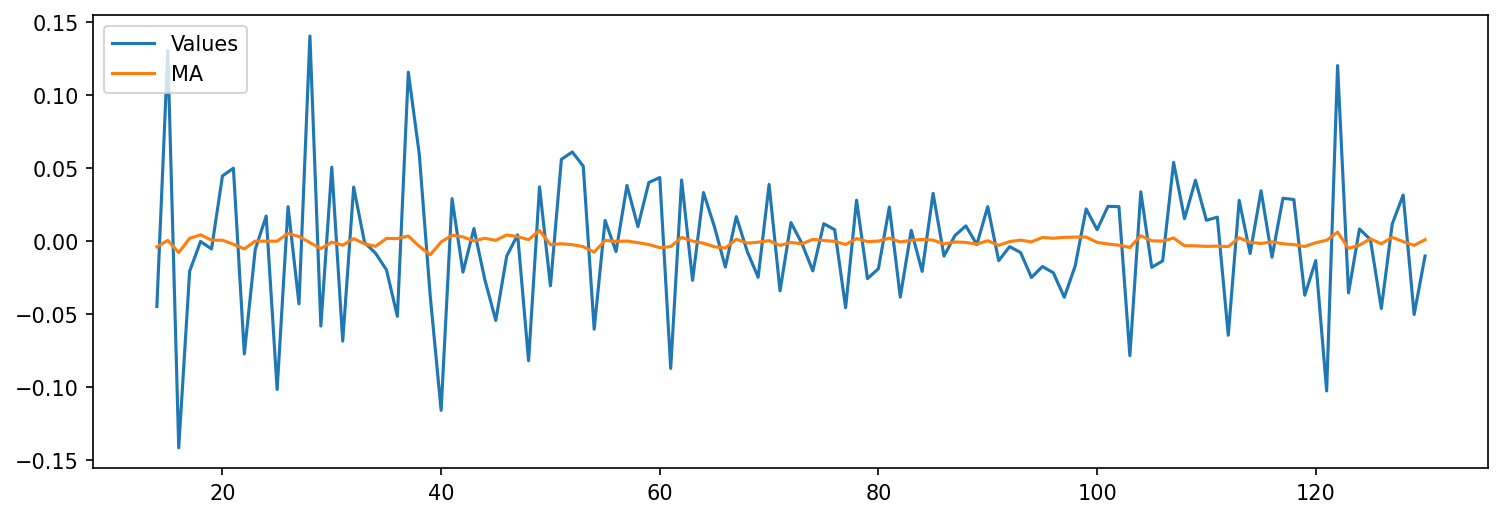

In [29]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(df["y"], label="Values")
plt.plot(ma, label="MA")
plt.legend(loc="upper left")
plt.show()

In [30]:
arma = (alpha+alpha2) + phi1*df["y1"] + phi2*df["y2"] + phi3*df["y3"] + phi12*df["y12"] + theta1*df["eps1"] + theta2*df["eps2"]

In [ ]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(df["y"], label="Values")
plt.plot(arma, label="ARMA")
plt.legend(loc="upper left")
plt.show()

## Прогнозирование

In [ ]:
dfna.head(20)

In [ ]:
df.head()

**Прогноз**

In [ ]:
ar = alpha + phi1*df["y1"] + phi2*df["y2"] + phi3*df["y3"] + phi12*df["y12"]
ma = alpha2 + theta1*df["eps1"] + theta2*df["eps2"]

ar_forecast = ar.values
ma_forecast = ma.values

for _ in range(12):
    ar_forecast = np.append(ar_forecast, alpha + phi1*ar_forecast[-1] + phi2*ar_forecast[-2] + phi3*ar_forecast[-3] + phi12*ar_forecast[-12])
    ma_forecast = np.append(ma_forecast, alpha2 + theta1*ma_forecast[-1] + theta2*ma_forecast[-2])

In [ ]:
arma_forecast = ar_forecast + ma_forecast

In [ ]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(df["y"].values, label="Values")
plt.plot(arma_forecast, label="Forecast")
plt.legend(loc="upper left")
plt.show()

In [ ]:
y_p = [np.nan if i < 24 else arma_forecast[i-24] for i in range(len(y))]
data["y_p"] = y_p

In [ ]:
data.head(30)

**Обратное дифференцирование с лагом 1**

In [ ]:
y_p_d1 = [np.nan if i < 24 else data["y_p"][i] + data["y_d1"][i] for i in range(len(y))]
data["y_p_d1"] = y_p_d1

In [ ]:
data.head(30)

**Обратное сезонное дифференцирование**

In [ ]:
y_p_sd = [np.nan if i < 24 else data["y_p_d1"][i] + data["y_bx"][i-12] for i in range(len(y))]
data["y_p_sd"] = y_p_sd

In [ ]:
data.head(30)

**Обратное преобразование Бокса-Кокса**

In [ ]:
from scipy.special import inv_boxcox

In [ ]:
data["y_p_bx"] = inv_boxcox(data["y_p_sd"], lambda_)

In [ ]:
data.head(30)

**Прогноз**

In [ ]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(passengers["num_passengers"][25:].values, label="Values")
plt.plot(data["y_p_bx"].values, label="Forecast")
plt.legend(loc="upper left")
plt.show()